Iniziamo la creazione della rete importando tutte le librerie che ci occorrono per creare il modello

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import tensorflow_datasets as tfds
import tensorflow as tf

Carichiamo il dataset emnist e sistemiamo le immagini siccome il dataset le importa girate di 90 gradi e specchiate

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.LZZRLK_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.LZZRLK_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.


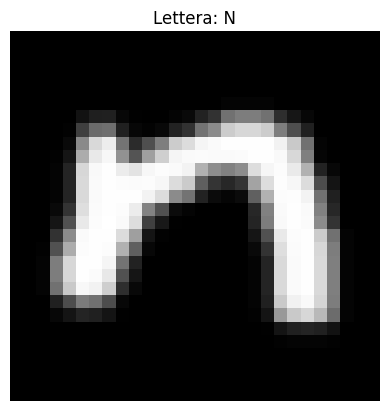

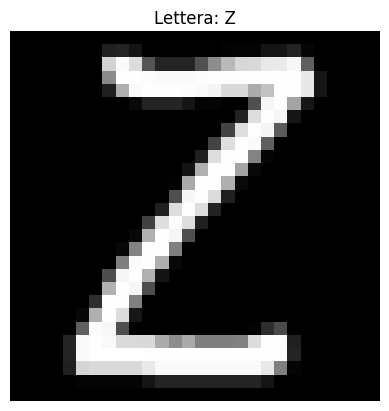

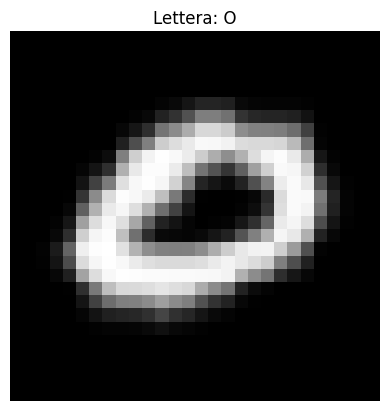

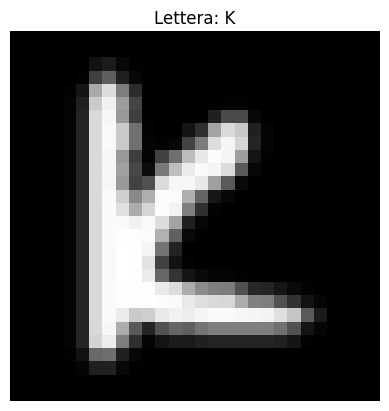

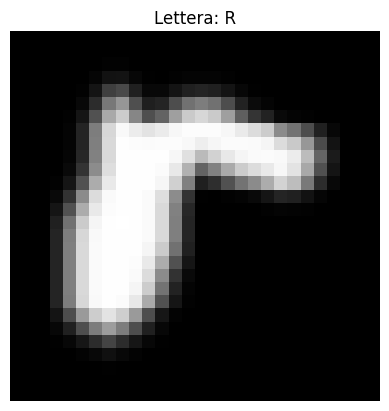

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=-1)
    image = tf.image.flip_left_right(image)
    label -= 1
    image = tf.expand_dims(image, -1)
    return image, label

batch_size = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in ds_train.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Lettera: {chr(int(labels[i]) + 65)}")  # 0='A'
        plt.axis("off")
        plt.show()

Ora definiamo la struttura del modello:
Creiamo un conv2d per estrarre i dati importanti(controni, bordi, etc...), col max pooling estraiamo il dato più significativo in una matrice 2x2 ed infine col dropout evitiamo l'overfitting.

Lo ripetiamo un'altra volta.

Usiamo flatten per appiattire l'immagine prima del dense in modo che il modello la possa leggere.
Elaboriamo le info col dense, ultimo dropout ed infine in output mettiamo soft max siccome abbiamo un output classificabile con 26 neuroni siccome le lettere sono 26.

Poi assegnamo al modello le direttive come optimizer, loss (che sarà sparse_categorical_crossentropy, funzione di perdita utilizzata in problemi di classificazione multi-classe, dove le etichette target sono rappresentate come interi, ovvero gli indici delle classi, invece di vettori one-hot).

Infine definiamo l'allenamento per l'IA.

In [9]:
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2775/2775 ━━━━━━━━━━━━━━━━━━━━ 101s 36ms/step - accuracy: 0.6270 - loss: 1.2355 - val_accuracy: 0.8762 - val_loss: 0.3942
Epoch 2/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 90s 32ms/step - accuracy: 0.8449 - loss: 0.4874 - val_accuracy: 0.8989 - val_loss: 0.3120
Epoch 3/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - accuracy: 0.8662 - loss: 0.4117 - val_accuracy: 0.9062 - val_loss: 0.2868
Epoch 4/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 135s 30ms/step - accuracy: 0.8808 - loss: 0.3689 - val_accuracy: 0.9086 - val_loss: 0.2767
Epoch 5/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 142s 30ms/step - accuracy: 0.8899 - loss: 0.3398 - val_accuracy: 0.9111 - val_loss: 0.2720
Epoch 6/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 141s 30ms/step - accuracy: 0.8945 - loss: 0.3193 - val_accuracy: 0.9137 - val_loss: 0.2549
Epoch 7/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 143s 30ms/step - accuracy: 0.9004 - loss: 0.3016 - val_accuracy: 0.9128 - val_loss: 0.2599
Epoch 8/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9022 - loss

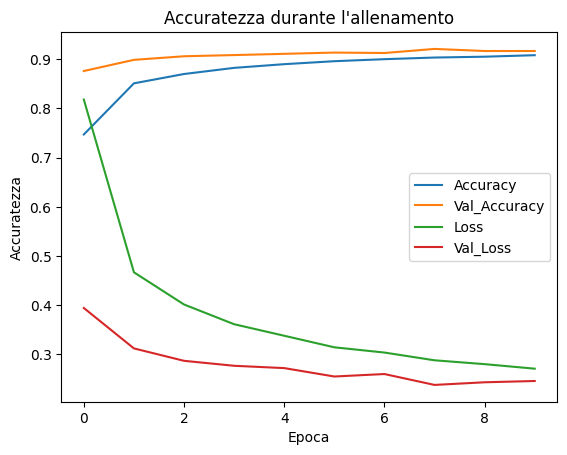

In [10]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('Accuratezza durante l\'allenamento')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.show()

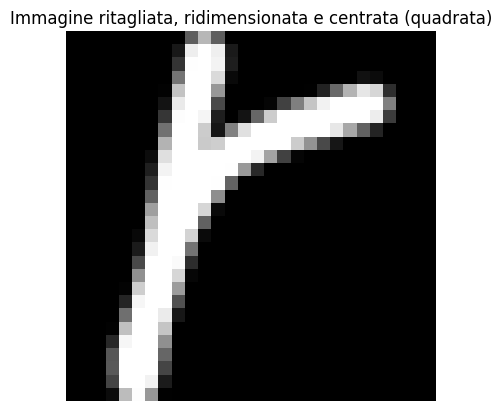

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


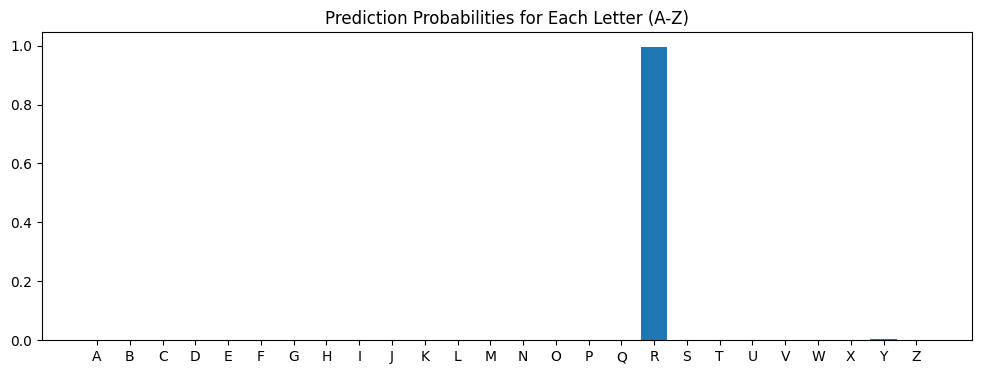

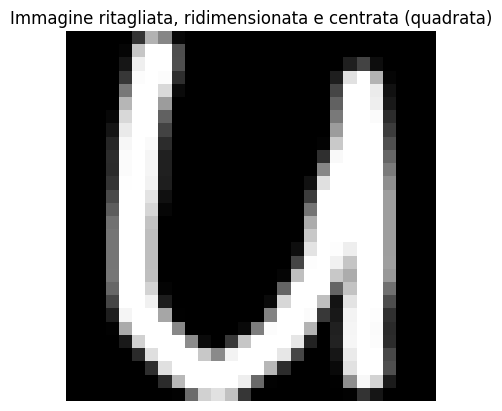

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


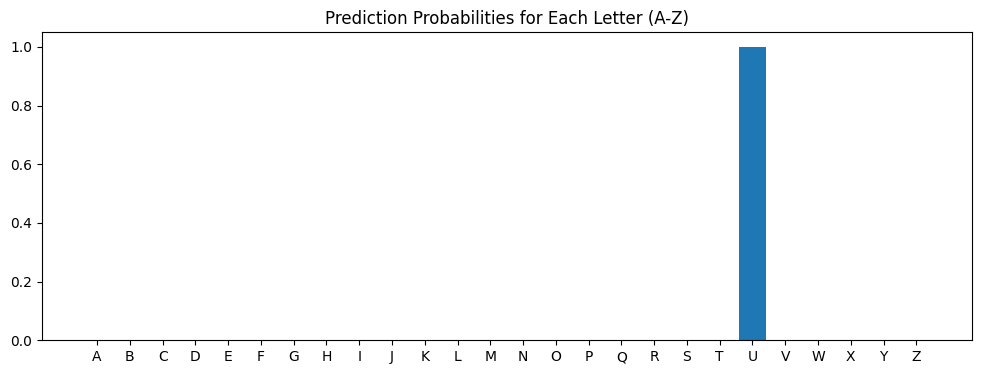

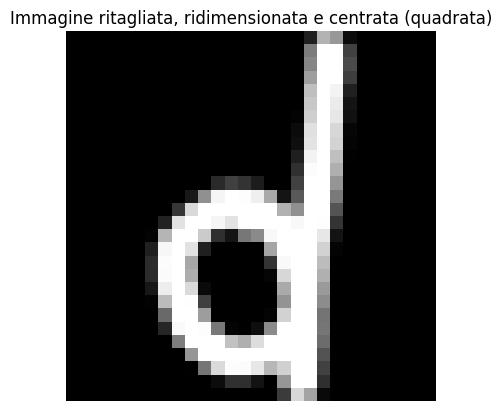

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


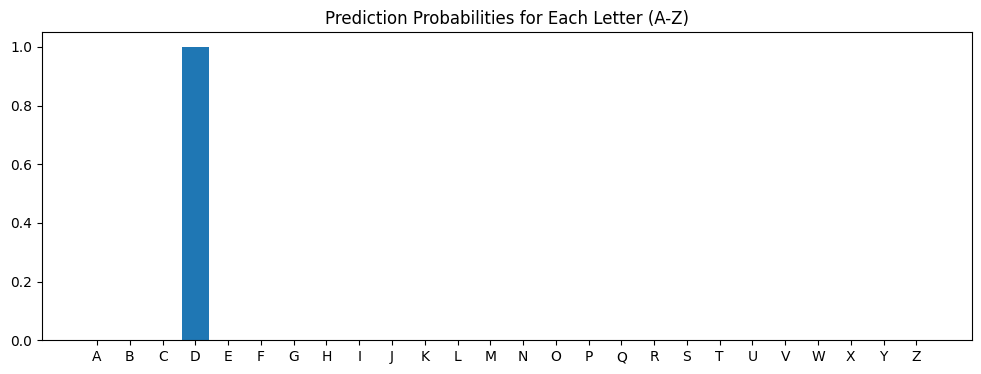

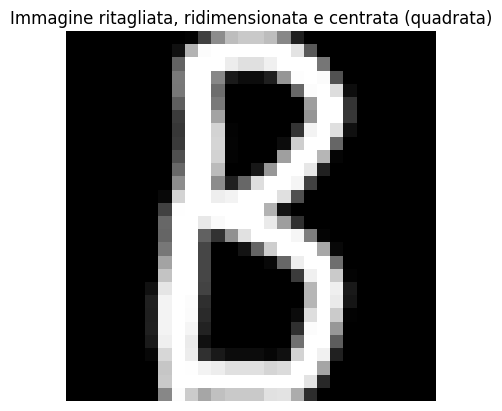

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


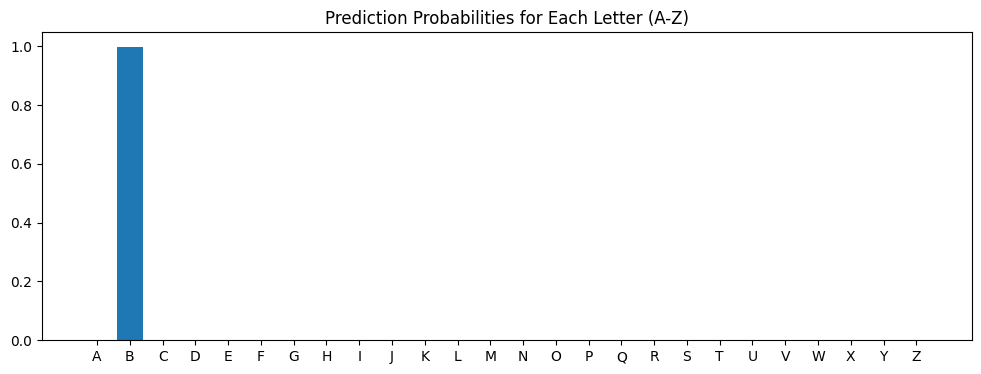

In [11]:
from IPython.display import display, HTML
from google.colab import output
import base64
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

canvas_html = """
<canvas id="canvas" width="280" height="280" style="border:1px solid black;"></canvas>
<br>
<button onclick="predict()">Predict</button>
<button onclick="clearCanvas()">Clear</button>

<script>
let canvas = document.getElementById('canvas');
let ctx = canvas.getContext('2d');
let drawing = false;

canvas.addEventListener('mousedown', () => { drawing = true; });
canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
canvas.addEventListener('mouseout', () => { drawing = false; ctx.beginPath(); });

canvas.addEventListener('mousemove', (event) => {
  if (!drawing) return;
  ctx.lineWidth = 20;
  ctx.lineCap = "round";
  ctx.strokeStyle = "white";
  ctx.lineTo(event.offsetX, event.offsetY);
  ctx.stroke();
  ctx.beginPath();
  ctx.moveTo(event.offsetX, event.offsetY);
});

ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);

function clearCanvas() {
  ctx.fillStyle = "black";
  ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function predict() {
  const dataURL = canvas.toDataURL();
  google.colab.kernel.invokeFunction('notebook.predict_digit', [dataURL], {});
}
</script>
"""

display(HTML(canvas_html))

def preprocess_image(img):
    img = img.convert('L')
    img_array = np.array(img)
    non_black_pixels = np.where(img_array > 0)
    if non_black_pixels[0].size > 0:
        y_min, x_min = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
        y_max, x_max = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
        max_dim = max(y_max - y_min, x_max - x_min)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        new_x_min = max(0, center_x - max_dim // 2 - 2)
        new_x_max = min(img_array.shape[1], center_x + max_dim // 2 + 2)
        new_y_min = max(0, center_y - max_dim // 2 - 2)
        new_y_max = min(img_array.shape[0], center_y + max_dim // 2 + 2)
        crop_width = new_x_max - new_x_min
        crop_height = new_y_max - new_y_min
        max_crop_dim = max(crop_width, crop_height)
        if crop_width < max_crop_dim:
            diff = max_crop_dim - crop_width
            new_x_min = max(0, new_x_min - diff // 2)
            new_x_max = min(img_array.shape[1], new_x_max + (diff - diff // 2))
        if crop_height < max_crop_dim:
            diff = max_crop_dim - crop_height
            new_y_min = max(0, new_y_min - diff // 2)
            new_y_max = min(img_array.shape[0], new_y_max + (diff - diff // 2))
        cropped_img_array = img_array[new_y_min:new_y_max, new_x_min:new_x_max]
        cropped_img = Image.fromarray(cropped_img_array)
    else:
        cropped_img = img
    size = max(cropped_img.size)
    new_img = Image.new('L', (size, size), color=0)
    new_img.paste(cropped_img, ((size - cropped_img.size[0]) // 2, (size - cropped_img.size[1]) // 2))
    new_img = new_img.resize((28, 28))
    plt.imshow(new_img, cmap='gray')
    plt.title('Immagine ritagliata, ridimensionata e centrata (quadrata)')
    plt.axis('off')
    plt.show()
    img_array = np.array(new_img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, -1)
    return np.expand_dims(img_array, 0)

def predict_digit(data):
    data = data.split(',')[1]
    binary = base64.b64decode(data)
    img = Image.open(io.BytesIO(binary))
    processed_img = preprocess_image(img)
    prediction = model.predict(processed_img)[0]
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)
    pred_letter = chr(pred_class + 65)
    display(HTML(f"<h3>Predicted: {pred_letter} (Confidence: {confidence:.2%})</h3>"))
    plt.figure(figsize=(12, 4))
    plt.bar(range(26), prediction)
    plt.xticks(range(26), [chr(i + 65) for i in range(26)])
    plt.title('Prediction Probabilities for Each Letter (A-Z)')
    plt.show()

output.register_callback('notebook.predict_digit', predict_digit)


Con questo blocco possiamo visualizzare i pesi del modello

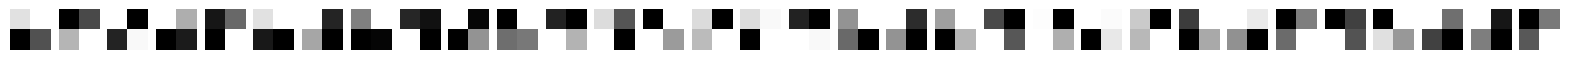

In [54]:
import matplotlib.pyplot as plt

# Prendi i pesi del primo layer conv2D
filters, biases = model.layers[0].get_weights()

# filters shape: (height, width, input_channels, num_filters)
num_filters = filters.shape[3]

fig, axes = plt.subplots(1, num_filters, figsize=(20,5))
for i in range(num_filters):
    f = filters[:, :, 0, i]  # prendi il filtro relativo al primo canale input
    axes[i].imshow(f, cmap='gray')
    axes[i].axis('off')
plt.show()